In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import tensorflow as tf
%matplotlib inline
import os
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(Dropout(0.5))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


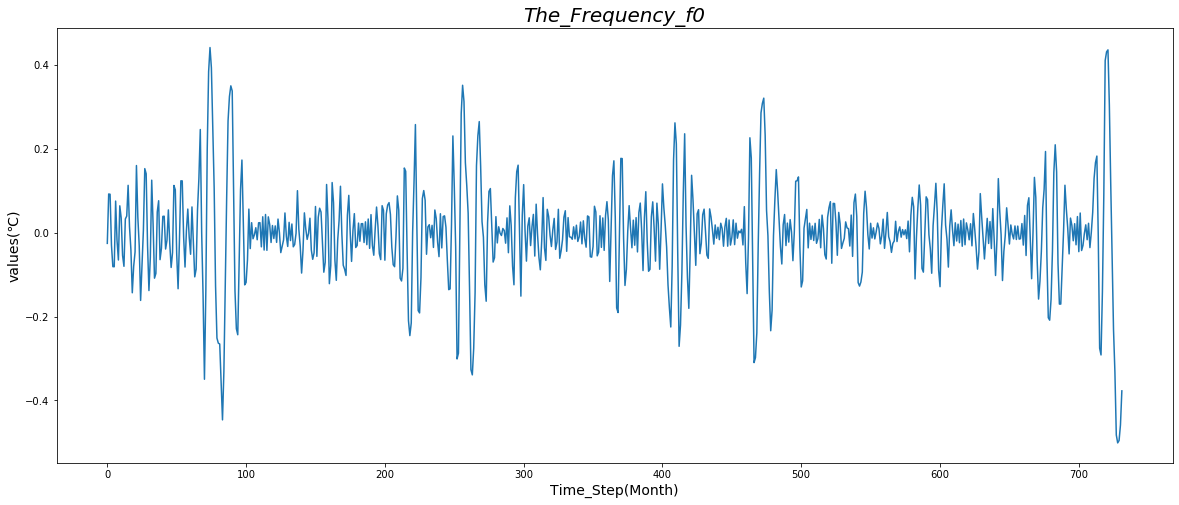

(684, 24, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 5s - loss: 0.0108
Epoch 2/200
 - 2s - loss: 0.0108
Epoch 3/200
 - 2s - loss: 0.0108
Epoch 4/200
 - 2s - loss: 0.0108
Epoch 5/200
 - 2s - loss: 0.0108
Epoch 6/200
 - 2s - loss: 0.0108
Epoch 7/200
 - 2s - loss: 0.0108
Epoch 8/200
 - 2s - loss: 0.0107
Epoch 9/200
 - 2s - loss: 0.0108
Epoch 10/200
 - 2s - loss: 0.0106
Epoch 11/200
 - 2s - loss: 0.0107
Epoch 12/200
 - 2s - loss: 0.0105
Epoch 13/200
 - 2s - loss: 0.0107
Epoch 14/200
 - 2s - loss: 0.0104
Epoch 15/200
 - 2s - loss: 0.0103
Epoch 16/200
 - 2s - loss: 0.0100
Epoch 17/200
 - 2s - loss: 0.0101
Epoch 18/200
 - 2s - loss: 0.0099
Epoch 19/200
 - 2s - loss: 0.0101
Epoch 20/200
 - 2s - loss: 0.0096
Epoch 21/200
 - 2s - loss: 0.0096
Epoch 22/200
 - 3s - loss: 0.0096
Epoch 23/200


(58, 12)


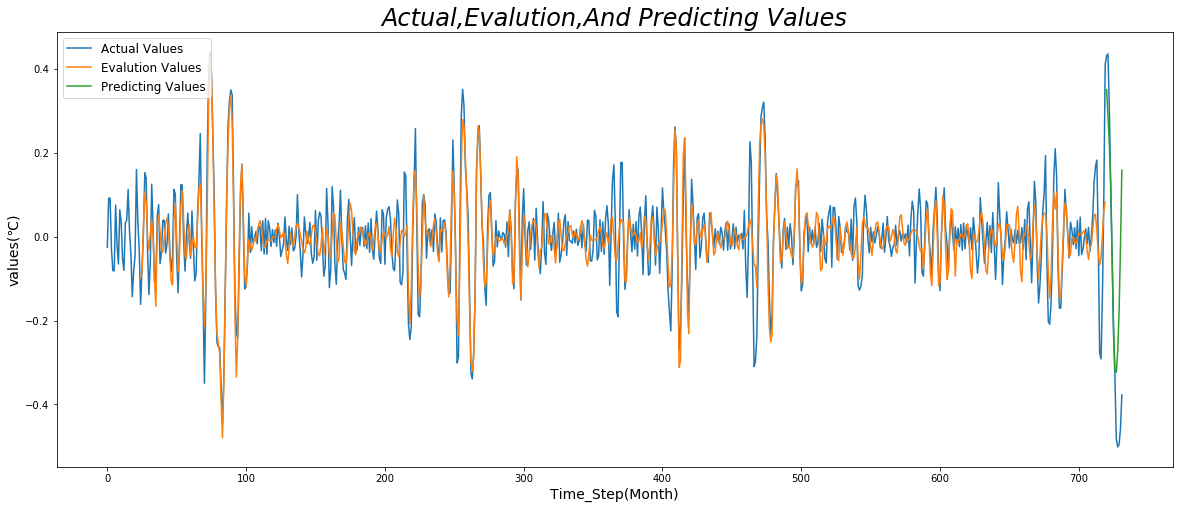

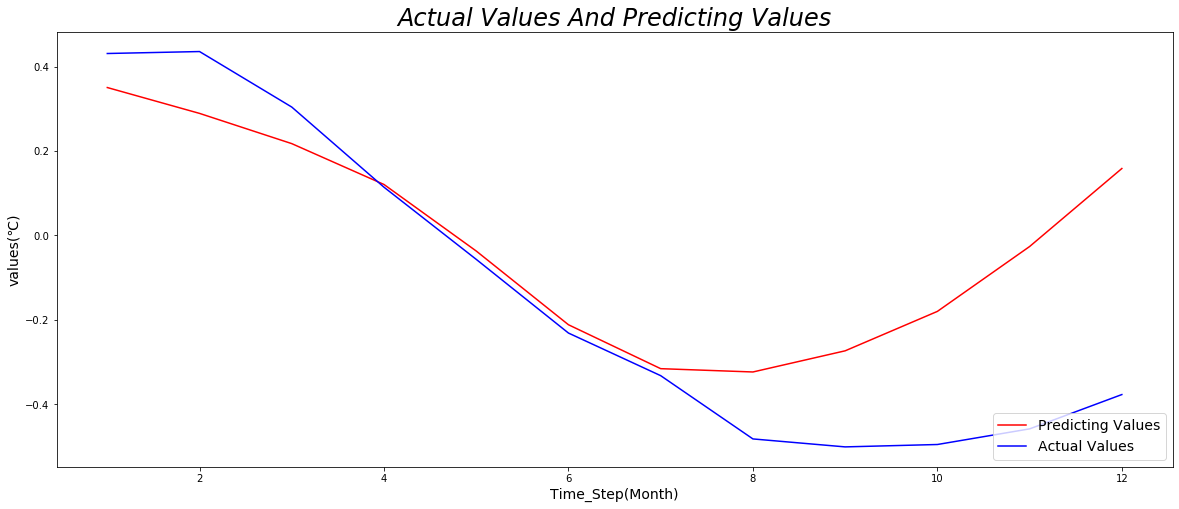

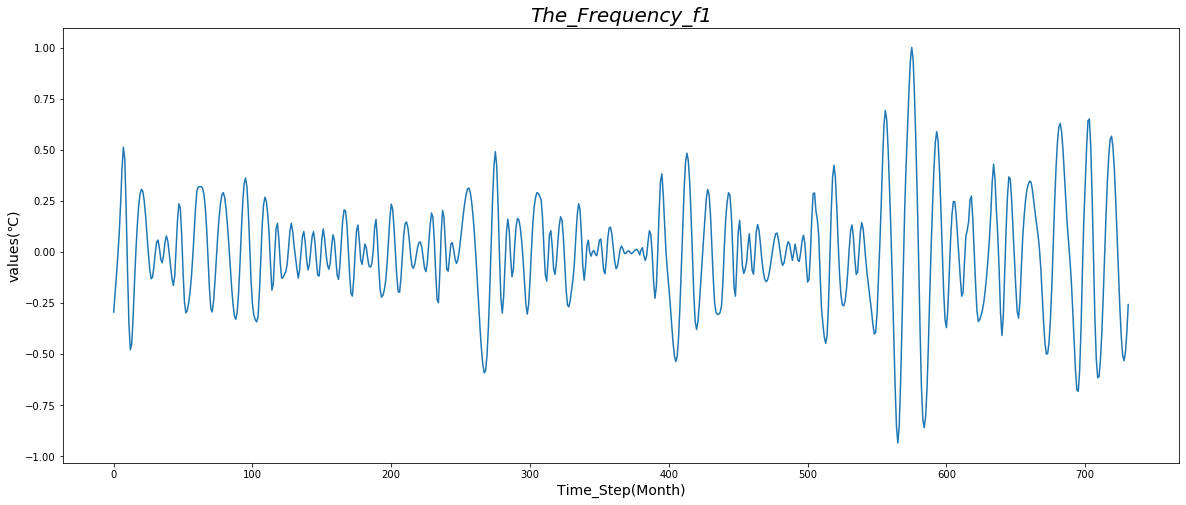

(684, 24, 1)
Epoch 1/200
 - 5s - loss: 0.0645
Epoch 2/200
 - 2s - loss: 0.0594
Epoch 3/200
 - 2s - loss: 0.0523
Epoch 4/200
 - 2s - loss: 0.0466
Epoch 5/200
 - 2s - loss: 0.0434
Epoch 6/200
 - 2s - loss: 0.0429
Epoch 7/200
 - 2s - loss: 0.0427
Epoch 8/200
 - 2s - loss: 0.0404
Epoch 9/200
 - 2s - loss: 0.0381
Epoch 10/200
 - 2s - loss: 0.0372
Epoch 11/200
 - 2s - loss: 0.0385
Epoch 12/200
 - 3s - loss: 0.0371
Epoch 13/200
 - 4s - loss: 0.0378
Epoch 14/200
 - 4s - loss: 0.0350
Epoch 15/200
 - 4s - loss: 0.0343
Epoch 16/200
 - 4s - loss: 0.0337
Epoch 17/200
 - 4s - loss: 0.0335
Epoch 18/200
 - 4s - loss: 0.0325
Epoch 19/200
 - 4s - loss: 0.0327
Epoch 20/200
 - 4s - loss: 0.0320
Epoch 21/200
 - 4s - loss: 0.0317
Epoch 22/200
 - 4s - loss: 0.0302
Epoch 23/200
 - 4s - loss: 0.0292
Epoch 24/200
 - 4s - loss: 0.0305
Epoch 25/200
 - 4s - loss: 0.0323
Epoch 26/200
 - 4s - loss: 0.0284
Epoch 27/200
 - 4s - loss: 0.0291
Epoch 28/200
 - 4s - loss: 0.0278
Epoch 29/200
 - 4s - loss: 0.0294
Epoch 30/2

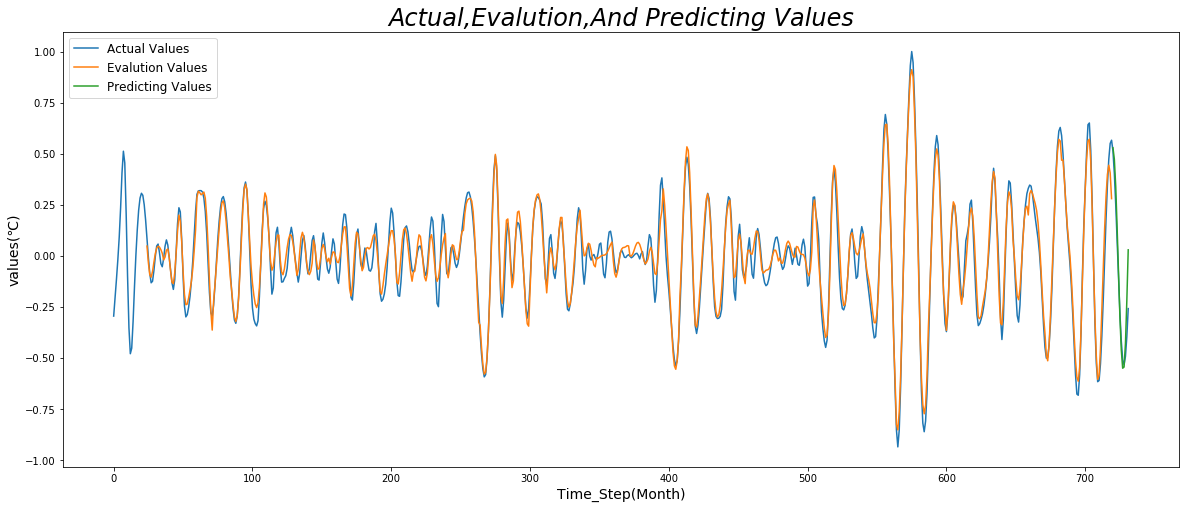

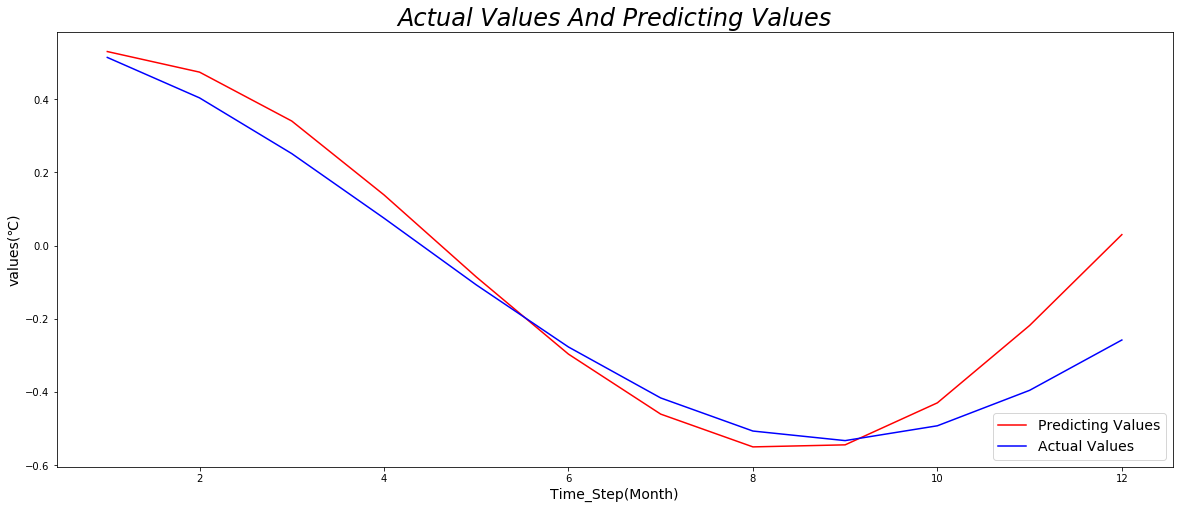

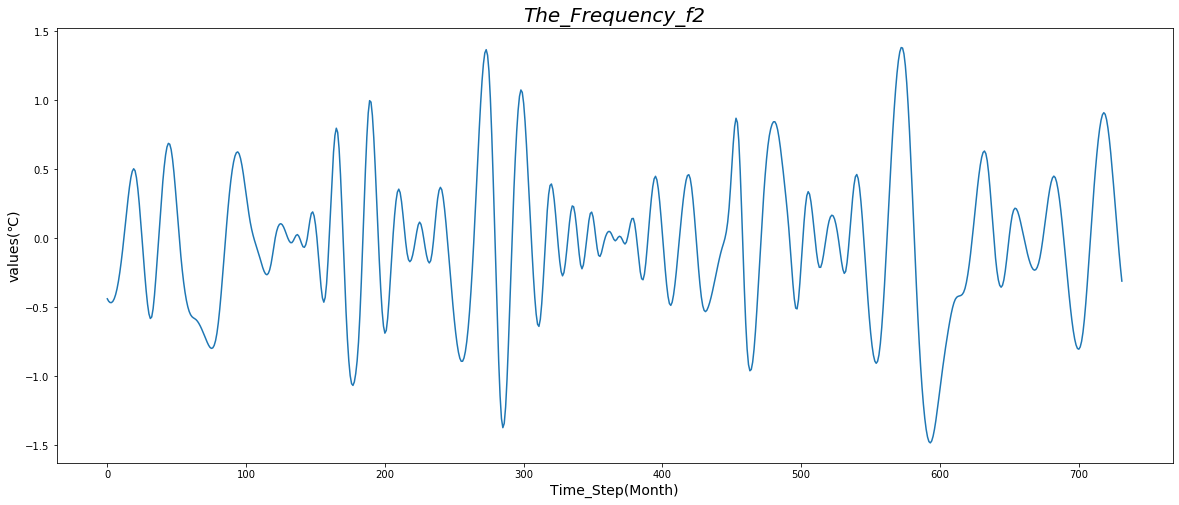

(684, 24, 1)
Epoch 1/200
 - 13s - loss: 0.2535
Epoch 2/200
 - 4s - loss: 0.2384
Epoch 3/200
 - 4s - loss: 0.2341
Epoch 4/200
 - 4s - loss: 0.2036
Epoch 5/200
 - 4s - loss: 0.1733
Epoch 6/200
 - 4s - loss: 0.1340
Epoch 7/200
 - 4s - loss: 0.1253
Epoch 8/200
 - 4s - loss: 0.1189
Epoch 9/200
 - 4s - loss: 0.1021
Epoch 10/200
 - 4s - loss: 0.0986
Epoch 11/200
 - 4s - loss: 0.0931
Epoch 12/200
 - 4s - loss: 0.0863
Epoch 13/200
 - 4s - loss: 0.0806
Epoch 14/200
 - 4s - loss: 0.0875
Epoch 15/200
 - 4s - loss: 0.0934
Epoch 16/200
 - 4s - loss: 0.0813
Epoch 17/200
 - 4s - loss: 0.0836
Epoch 18/200
 - 4s - loss: 0.0777
Epoch 19/200
 - 4s - loss: 0.0669
Epoch 20/200
 - 4s - loss: 0.0639
Epoch 21/200
 - 4s - loss: 0.0641
Epoch 22/200
 - 4s - loss: 0.0777
Epoch 23/200
 - 4s - loss: 0.0748
Epoch 24/200
 - 4s - loss: 0.0619
Epoch 25/200
 - 4s - loss: 0.0581
Epoch 26/200
 - 4s - loss: 0.0525
Epoch 27/200
 - 4s - loss: 0.0553
Epoch 28/200
 - 4s - loss: 0.0579
Epoch 29/200
 - 4s - loss: 0.0608
Epoch 30/

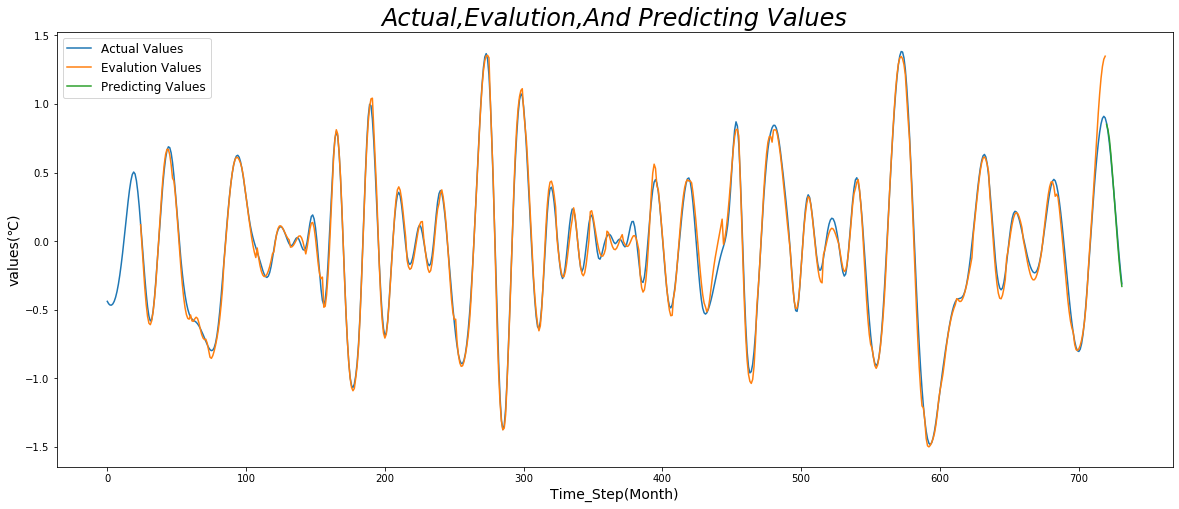

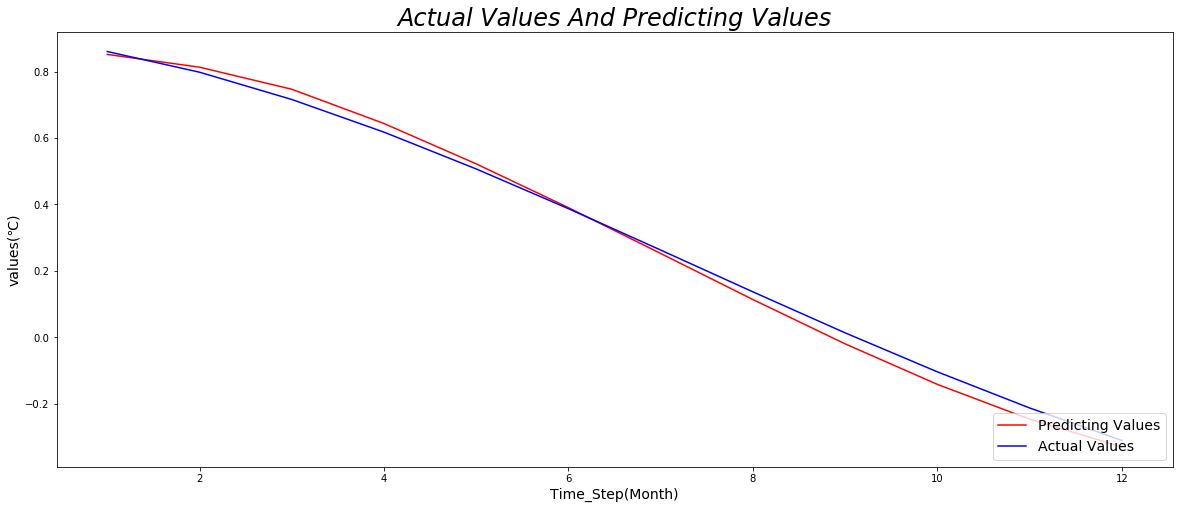

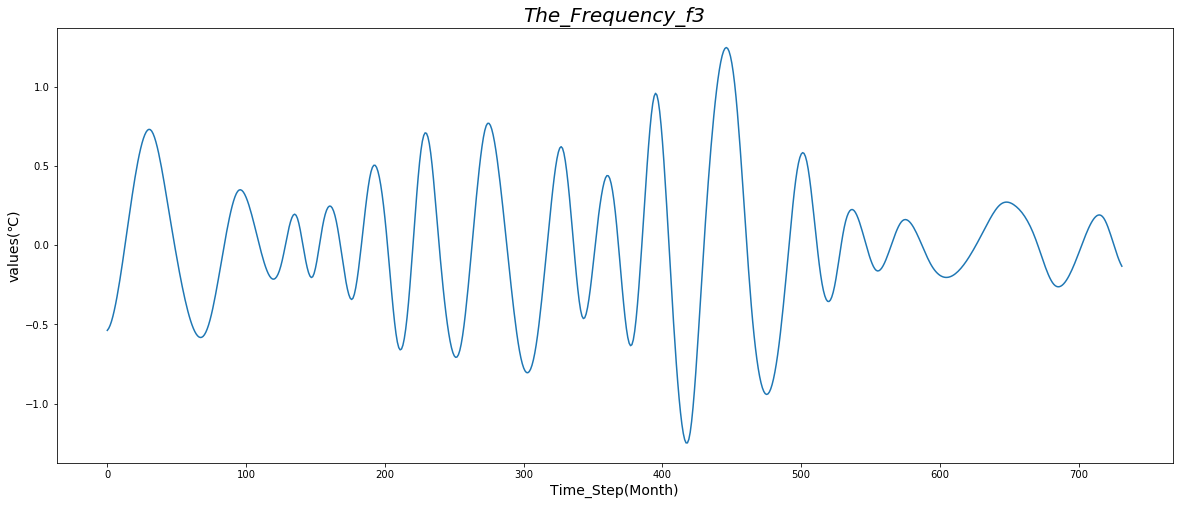

(684, 24, 1)
Epoch 1/200
 - 12s - loss: 0.1503
Epoch 2/200
 - 4s - loss: 0.1127
Epoch 3/200
 - 4s - loss: 0.0835
Epoch 4/200
 - 5s - loss: 0.0651
Epoch 5/200
 - 4s - loss: 0.0496
Epoch 6/200
 - 4s - loss: 0.0557
Epoch 7/200
 - 5s - loss: 0.0385
Epoch 8/200
 - 5s - loss: 0.0356
Epoch 9/200
 - 5s - loss: 0.0346
Epoch 10/200
 - 4s - loss: 0.0300
Epoch 11/200
 - 4s - loss: 0.0255
Epoch 12/200
 - 4s - loss: 0.0232
Epoch 13/200
 - 4s - loss: 0.0169
Epoch 14/200
 - 4s - loss: 0.0190
Epoch 15/200
 - 5s - loss: 0.0172
Epoch 16/200
 - 4s - loss: 0.0187
Epoch 17/200
 - 5s - loss: 0.0186
Epoch 18/200
 - 5s - loss: 0.0191
Epoch 19/200
 - 4s - loss: 0.0226
Epoch 20/200
 - 4s - loss: 0.0242
Epoch 21/200
 - 5s - loss: 0.0159
Epoch 22/200
 - 4s - loss: 0.0140
Epoch 23/200
 - 5s - loss: 0.0133
Epoch 24/200
 - 4s - loss: 0.0128
Epoch 25/200
 - 4s - loss: 0.0141
Epoch 26/200
 - 5s - loss: 0.0149
Epoch 27/200
 - 5s - loss: 0.0125
Epoch 28/200
 - 5s - loss: 0.0122
Epoch 29/200
 - 4s - loss: 0.0146
Epoch 30/

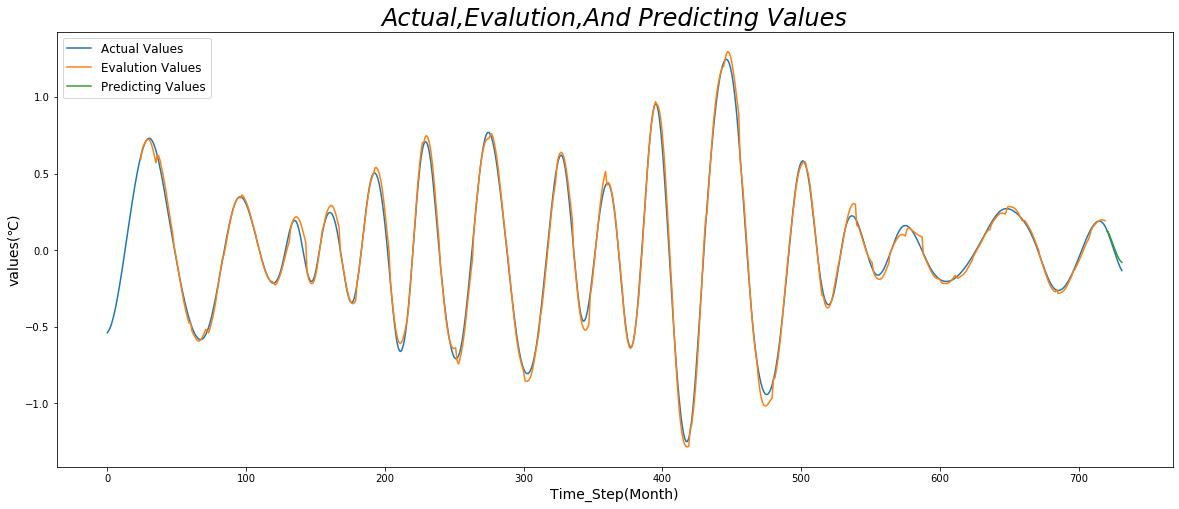

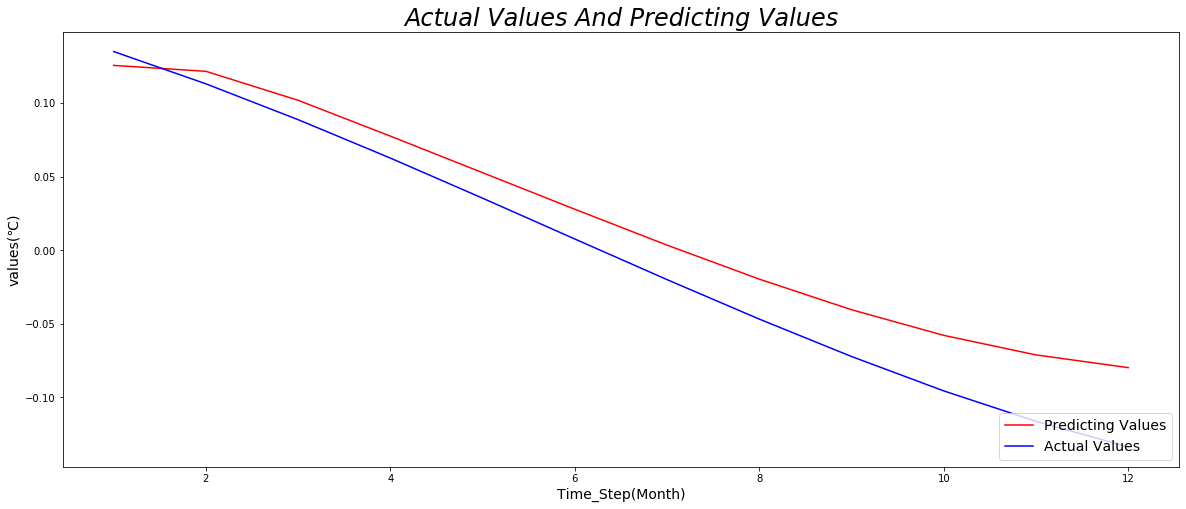

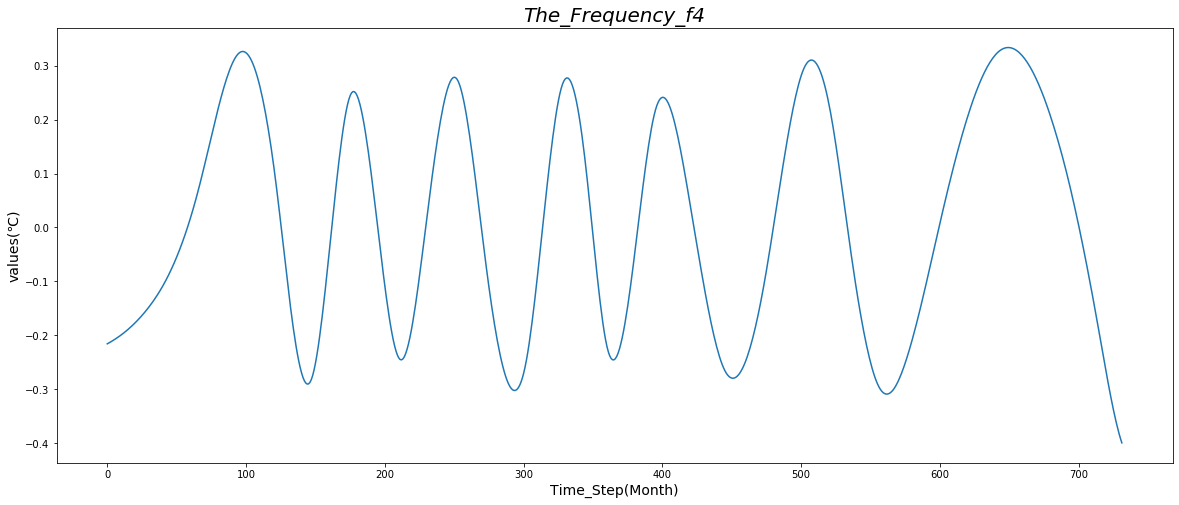

(684, 24, 1)
Epoch 1/200
 - 12s - loss: 0.0296
Epoch 2/200
 - 5s - loss: 0.0105
Epoch 3/200
 - 5s - loss: 0.0055
Epoch 4/200
 - 5s - loss: 0.0042
Epoch 5/200
 - 5s - loss: 0.0032
Epoch 6/200
 - 5s - loss: 0.0027
Epoch 7/200
 - 5s - loss: 0.0019
Epoch 8/200
 - 5s - loss: 0.0018
Epoch 9/200
 - 5s - loss: 0.0020
Epoch 10/200
 - 5s - loss: 0.0018
Epoch 11/200
 - 5s - loss: 0.0016
Epoch 12/200
 - 5s - loss: 0.0020
Epoch 13/200
 - 5s - loss: 0.0015
Epoch 14/200
 - 5s - loss: 0.0016
Epoch 15/200
 - 5s - loss: 0.0014
Epoch 16/200
 - 5s - loss: 0.0016
Epoch 17/200
 - 5s - loss: 0.0017
Epoch 18/200
 - 5s - loss: 0.0013
Epoch 19/200
 - 5s - loss: 0.0010
Epoch 20/200
 - 5s - loss: 0.0013
Epoch 21/200
 - 5s - loss: 0.0013
Epoch 22/200
 - 5s - loss: 0.0012
Epoch 23/200
 - 5s - loss: 0.0013
Epoch 24/200
 - 5s - loss: 0.0012
Epoch 25/200
 - 5s - loss: 0.0012
Epoch 26/200
 - 5s - loss: 0.0010
Epoch 27/200
 - 5s - loss: 0.0011
Epoch 28/200
 - 5s - loss: 0.0013
Epoch 29/200
 - 5s - loss: 0.0012
Epoch 30/

(58, 12)


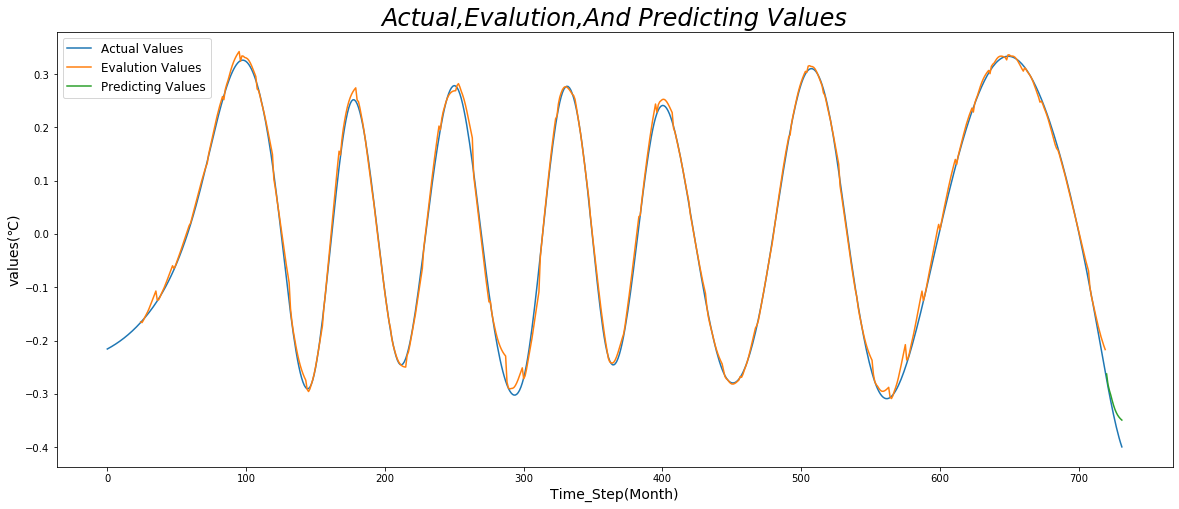

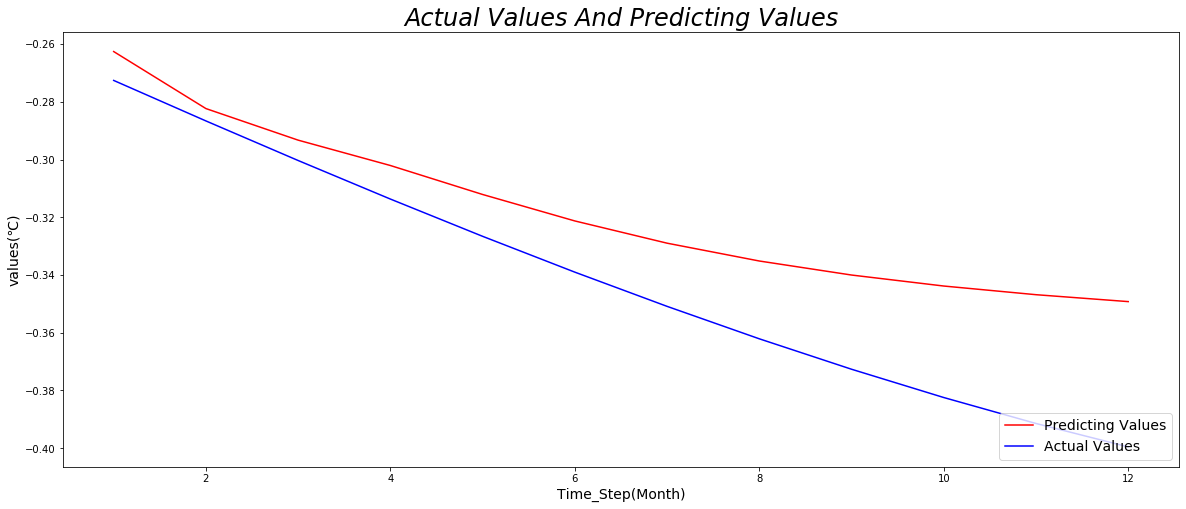

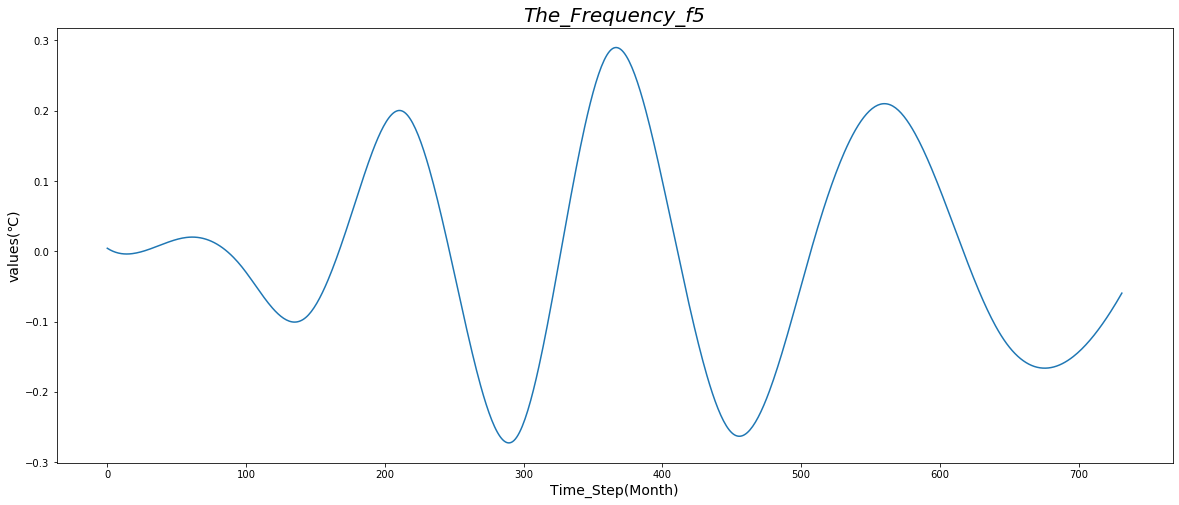

(684, 24, 1)
Epoch 1/200
 - 12s - loss: 0.0133
Epoch 2/200
 - 5s - loss: 0.0046
Epoch 3/200
 - 5s - loss: 0.0021
Epoch 4/200
 - 5s - loss: 0.0012
Epoch 5/200
 - 5s - loss: 8.0745e-04
Epoch 6/200
 - 5s - loss: 7.2480e-04
Epoch 7/200
 - 5s - loss: 7.0528e-04
Epoch 8/200
 - 5s - loss: 6.2123e-04
Epoch 9/200
 - 5s - loss: 7.2712e-04
Epoch 10/200
 - 5s - loss: 7.7083e-04
Epoch 11/200
 - 5s - loss: 5.2885e-04
Epoch 12/200
 - 5s - loss: 4.8700e-04
Epoch 13/200
 - 5s - loss: 4.0958e-04
Epoch 14/200
 - 5s - loss: 4.7719e-04
Epoch 15/200
 - 5s - loss: 4.1312e-04
Epoch 16/200
 - 5s - loss: 3.8043e-04
Epoch 17/200
 - 5s - loss: 3.6230e-04
Epoch 18/200
 - 5s - loss: 3.5231e-04
Epoch 19/200
 - 5s - loss: 3.2240e-04
Epoch 20/200
 - 6s - loss: 3.2264e-04
Epoch 21/200
 - 5s - loss: 3.2124e-04
Epoch 22/200
 - 5s - loss: 4.0083e-04
Epoch 23/200
 - 5s - loss: 3.4017e-04
Epoch 24/200
 - 5s - loss: 3.7258e-04
Epoch 25/200
 - 5s - loss: 3.8821e-04
Epoch 26/200
 - 5s - loss: 3.2882e-04
Epoch 27/200
 - 5s - lo

(58, 12)


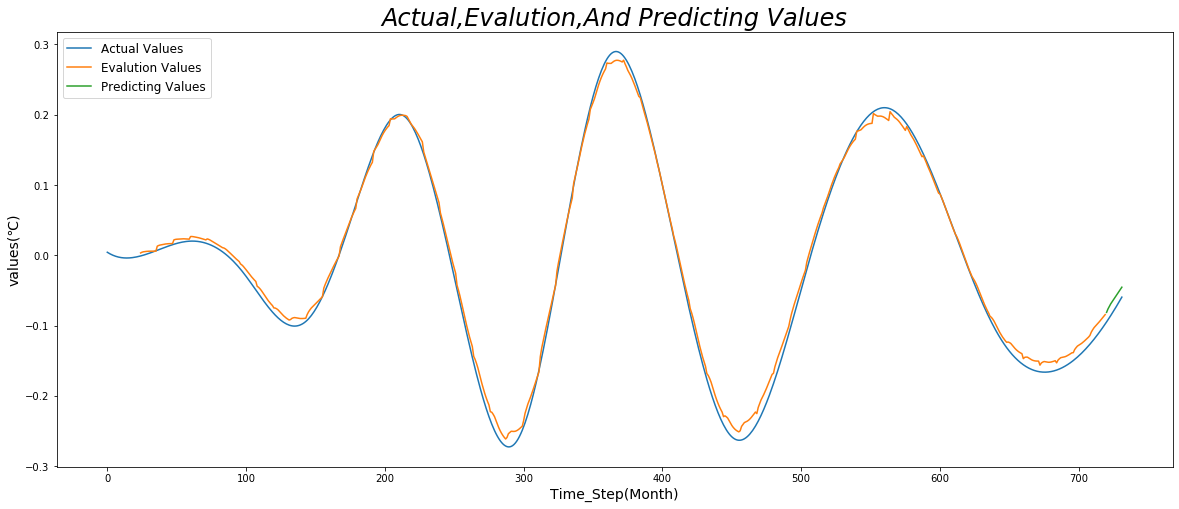

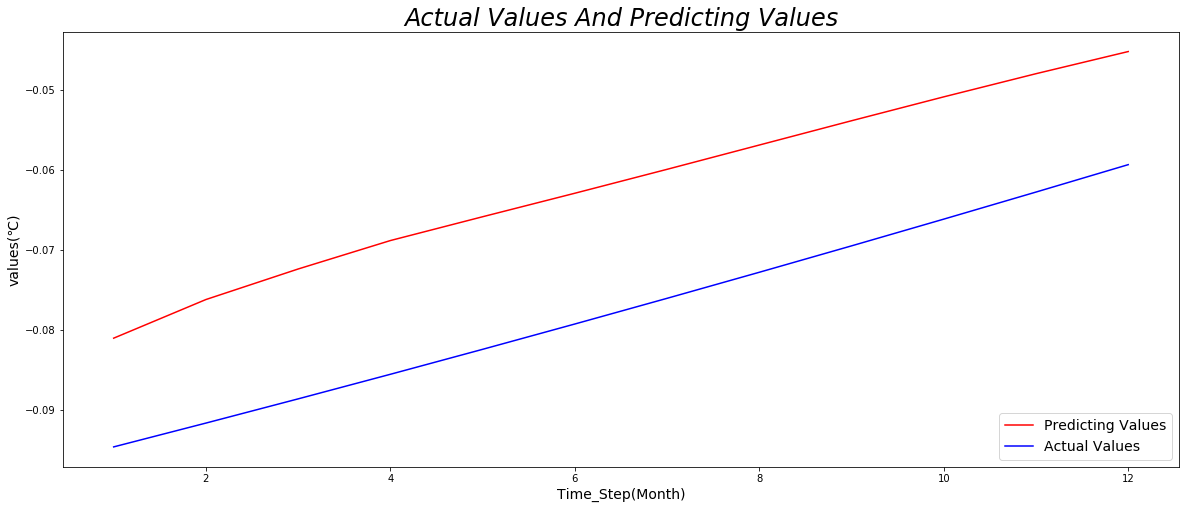

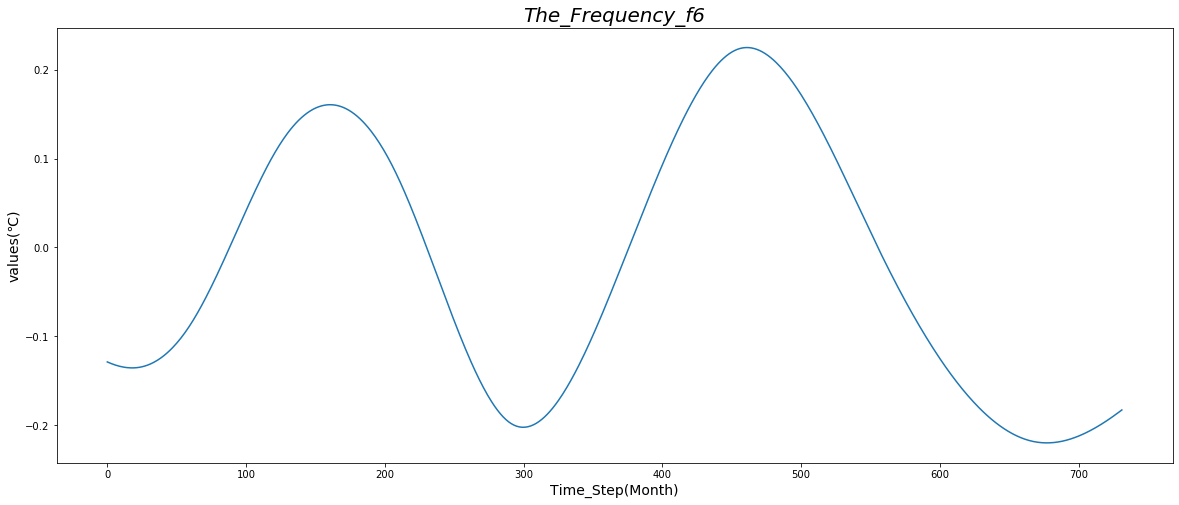

(684, 24, 1)
Epoch 1/200
 - 13s - loss: 0.0103
Epoch 2/200
 - 6s - loss: 0.0038
Epoch 3/200
 - 6s - loss: 0.0021
Epoch 4/200
 - 6s - loss: 9.8383e-04
Epoch 5/200
 - 6s - loss: 6.2720e-04
Epoch 6/200
 - 6s - loss: 4.2868e-04
Epoch 7/200
 - 6s - loss: 3.3388e-04
Epoch 8/200
 - 6s - loss: 3.4321e-04
Epoch 9/200
 - 6s - loss: 3.2838e-04
Epoch 10/200
 - 6s - loss: 2.8339e-04
Epoch 11/200
 - 6s - loss: 2.8097e-04
Epoch 12/200
 - 6s - loss: 2.7107e-04
Epoch 13/200
 - 6s - loss: 2.6492e-04
Epoch 14/200
 - 6s - loss: 2.3902e-04
Epoch 15/200
 - 6s - loss: 3.2237e-04
Epoch 16/200
 - 6s - loss: 3.0099e-04
Epoch 17/200
 - 6s - loss: 2.7687e-04
Epoch 18/200
 - 6s - loss: 2.5986e-04
Epoch 19/200
 - 6s - loss: 3.6608e-04
Epoch 20/200
 - 6s - loss: 2.7049e-04
Epoch 21/200
 - 6s - loss: 3.4321e-04
Epoch 22/200
 - 6s - loss: 2.7881e-04
Epoch 23/200
 - 6s - loss: 2.3346e-04
Epoch 24/200
 - 6s - loss: 2.2518e-04
Epoch 25/200
 - 6s - loss: 2.4260e-04
Epoch 26/200
 - 6s - loss: 3.3969e-04
Epoch 27/200
 - 6s 

(58, 12)


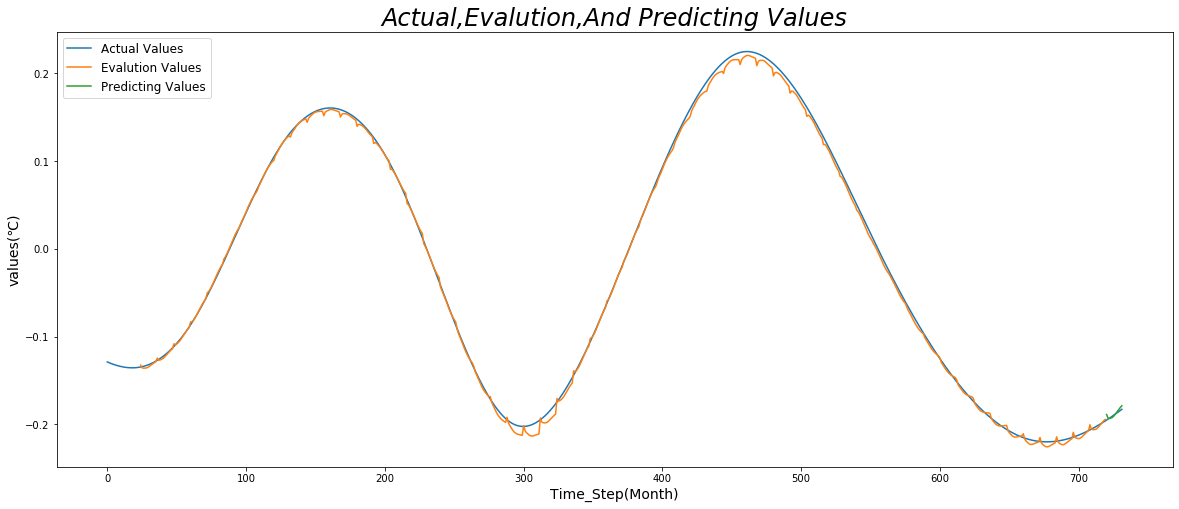

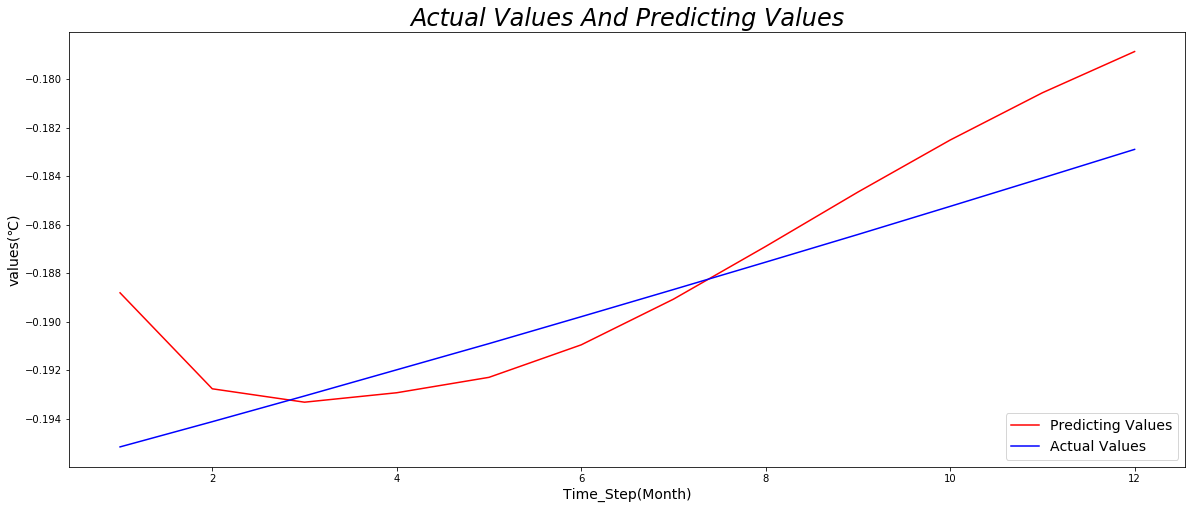

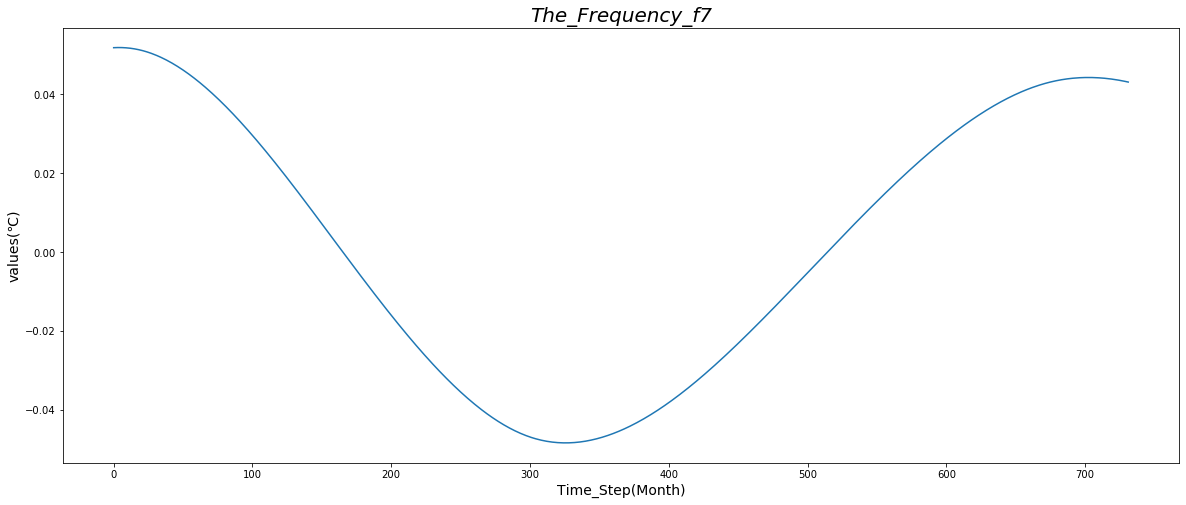

(684, 24, 1)
Epoch 1/200
 - 13s - loss: 7.0291e-04
Epoch 2/200
 - 6s - loss: 2.3623e-04
Epoch 3/200
 - 6s - loss: 1.4557e-04
Epoch 4/200
 - 6s - loss: 1.0671e-04
Epoch 5/200
 - 6s - loss: 9.1220e-05
Epoch 6/200
 - 6s - loss: 7.8338e-05
Epoch 7/200
 - 6s - loss: 6.9376e-05
Epoch 8/200
 - 6s - loss: 5.4204e-05
Epoch 9/200
 - 6s - loss: 5.0265e-05
Epoch 10/200
 - 6s - loss: 5.4943e-05
Epoch 11/200
 - 6s - loss: 4.4492e-05
Epoch 12/200
 - 6s - loss: 4.6900e-05
Epoch 13/200
 - 6s - loss: 4.6776e-05
Epoch 14/200
 - 6s - loss: 3.8852e-05
Epoch 15/200
 - 6s - loss: 4.4004e-05
Epoch 16/200
 - 6s - loss: 3.4465e-05
Epoch 17/200
 - 6s - loss: 2.9279e-05
Epoch 18/200
 - 6s - loss: 3.9424e-05
Epoch 19/200
 - 6s - loss: 3.2493e-05
Epoch 20/200
 - 6s - loss: 3.0937e-05
Epoch 21/200
 - 6s - loss: 2.0946e-05
Epoch 22/200
 - 6s - loss: 1.8607e-05
Epoch 23/200
 - 6s - loss: 1.7275e-05
Epoch 24/200
 - 6s - loss: 1.4474e-05
Epoch 25/200
 - 6s - loss: 2.1325e-05
Epoch 26/200
 - 6s - loss: 2.6029e-05
Epoch 2

(58, 12)


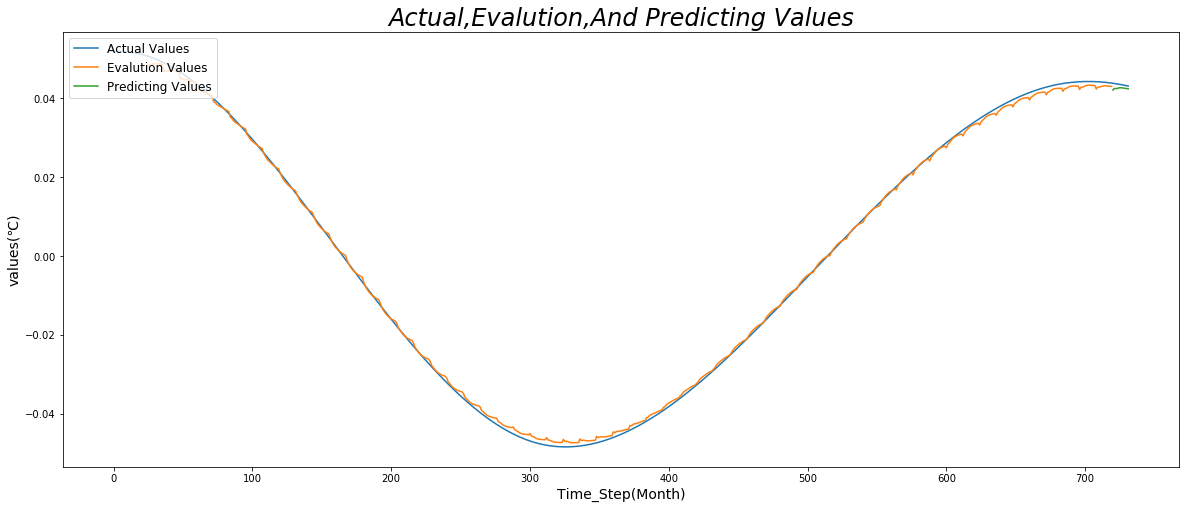

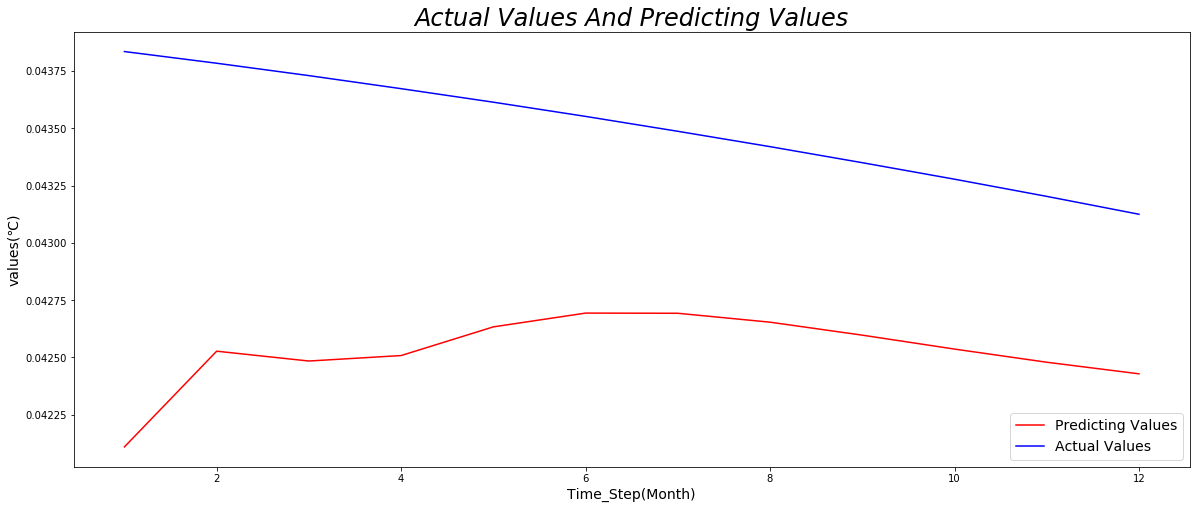

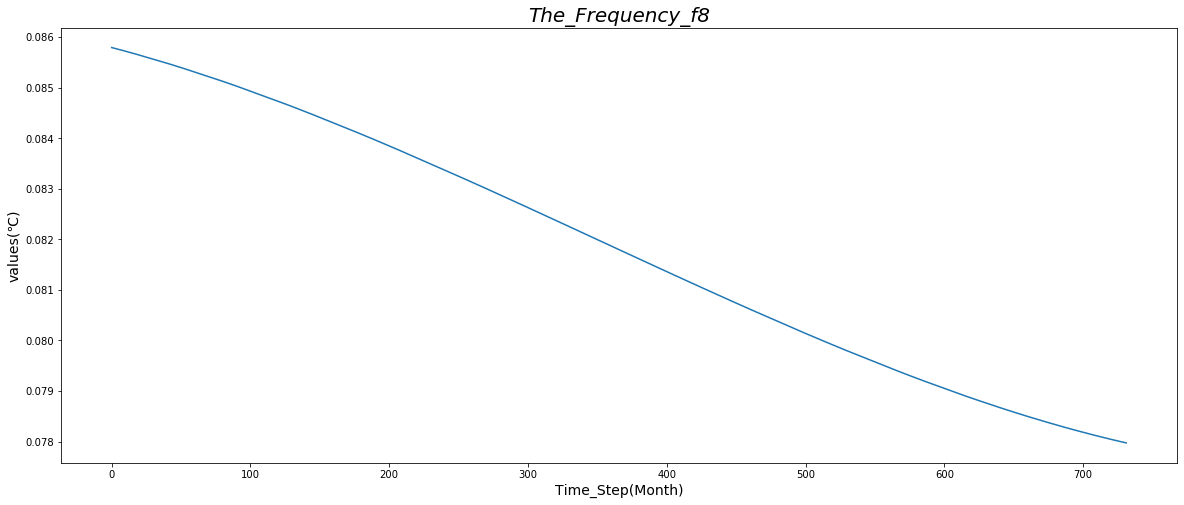

(684, 24, 1)
Epoch 1/200
 - 14s - loss: 6.0299e-04
Epoch 2/200
 - 6s - loss: 1.4376e-05
Epoch 3/200
 - 6s - loss: 7.4763e-06
Epoch 4/200
 - 6s - loss: 6.7770e-06
Epoch 5/200
 - 6s - loss: 6.8382e-06
Epoch 6/200
 - 6s - loss: 6.8567e-06
Epoch 7/200
 - 6s - loss: 6.1134e-06
Epoch 8/200
 - 6s - loss: 6.3610e-06
Epoch 9/200
 - 6s - loss: 6.0156e-06
Epoch 10/200
 - 6s - loss: 5.9078e-06
Epoch 11/200
 - 6s - loss: 5.9915e-06
Epoch 12/200
 - 6s - loss: 6.1023e-06
Epoch 13/200
 - 6s - loss: 6.1795e-06
Epoch 14/200
 - 6s - loss: 6.0656e-06
Epoch 15/200
 - 6s - loss: 5.5596e-06
Epoch 16/200
 - 6s - loss: 6.0834e-06
Epoch 17/200
 - 6s - loss: 6.2377e-06
Epoch 18/200
 - 6s - loss: 5.5609e-06
Epoch 19/200
 - 6s - loss: 5.7086e-06
Epoch 20/200
 - 6s - loss: 5.5998e-06
Epoch 21/200
 - 6s - loss: 5.6568e-06
Epoch 22/200
 - 6s - loss: 6.0225e-06
Epoch 23/200
 - 6s - loss: 5.4559e-06
Epoch 24/200
 - 7s - loss: 5.5551e-06
Epoch 25/200
 - 6s - loss: 5.3808e-06
Epoch 26/200
 - 6s - loss: 5.3920e-06
Epoch 2

(58, 12)


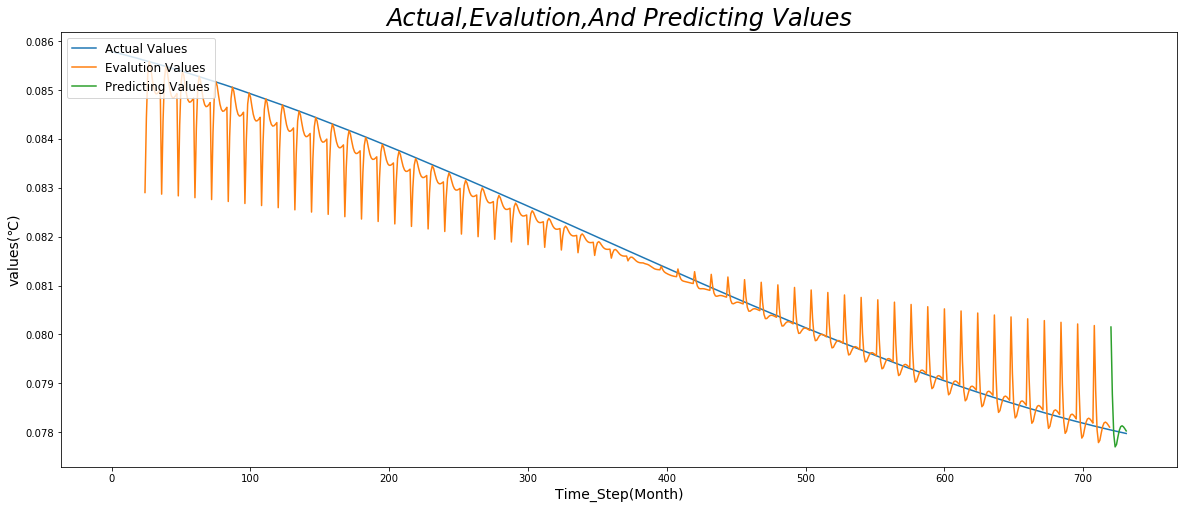

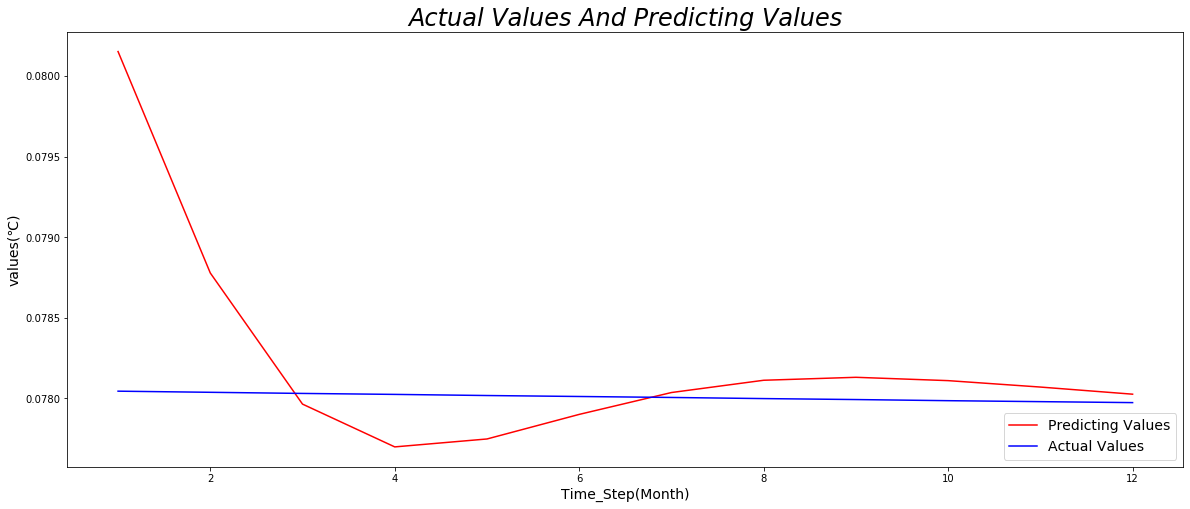

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-96]

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.08015177]
 [0.07877757]
 [0.07796371]
 [0.07769819]
 [0.07774732]
 [0.07789987]
 [0.07803555]
 [0.07811172]
 [0.0781301 ]
 [0.0781094 ]
 [0.07806955]
 [0.0780253 ]]
[array([ 0.43136 ,  0.436   ,  0.30437 ,  0.11433 , -0.056745, -0.2315  ,
       -0.33256 , -0.48256 , -0.50144 , -0.49578 , -0.4587  , -0.37735 ]), array([ 0.51384 ,  0.40337 ,  0.25116 ,  0.074913, -0.10717 , -0.2769  ,
       -0.41605 , -0.50644 , -0.53256 , -0.49206 , -0.39524 , -0.25782 ]), array([ 0.86033,  0.79815,  0.71602,  0.61767,  0.50684,  0.38725,
        0.26266,  0.13679,  0.01337, -0.10405, -0.21276, -0.31057]), array([ 0.13498  ,  0.11305  ,  0.08871  ,  0.062607 ,  0.035372 ,
        0.0076416, -0.01995  , -0.046766 , -0.072172 , -0.095532 ,
       -0.11621  , -0.13357  ]), array([-0.2726 , -0.28663, -0.30034, -0.31369, -0.3266 , -0.33901,
       -0.35086, -0.3621 , -0.37264, -0.38244, -0.39143, -0.39954]), array([-0.094611, -0.091635, -0.08861 , -0.085538, -0.082419, -0.079254,
       -0.076044, -0.0

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[ 0.43136   0.436     0.30437   0.11433  -0.056745 -0.2315   -0.33256
 -0.48256  -0.50144  -0.49578  -0.4587   -0.37735 ]
[[ 0.43136 ]
 [ 0.436   ]
 [ 0.30437 ]
 [ 0.11433 ]
 [-0.056745]
 [-0.2315  ]
 [-0.33256 ]
 [-0.48256 ]
 [-0.50144 ]
 [-0.49578 ]
 [-0.4587  ]
 [-0.37735 ]]
[[ 0.43]
 [ 0.44]
 [ 0.3 ]
 [ 0.11]
 [-0.06]
 [-0.23]
 [-0.33]
 [-0.48]
 [-0.5 ]
 [-0.5 ]
 [-0.46]
 [-0.38]]
-----------------------------------
observe value:[ 0.51384   0.40337   0.25116   0.074913 -0.10717  -0.2769   -0.41605
 -0.50644  -0.53256  -0.49206  -0.39524  -0.25782 ]
[[ 0.9452  ]
 [ 0.83937 ]
 [ 0.55553 ]
 [ 0.189243]
 [-0.163915]
 [-0.5084  ]
 [-0.74861 ]
 [-0.989   ]
 [-1.034   ]
 [-0.98784 ]
 [-0.85394 ]
 [-0.63517 ]]
[[ 0.95]
 [ 0.84]
 [ 0.56]
 [ 0.19]
 [-0.16]
 [-0.51]
 [-0.75]
 [-0.99]
 [-1.03]
 [-0.99]
 [-0.85]
 [-0.64]]
-----------------------------------
observe value:[ 0.86033  0.79815  0.71602  0.61767  0.50684  0.38725  0.26266  0.13679
  0.01337 -0.10405 -0.21276 -0.31057]

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.35066557  0.2893577   0.21766047  0.12077466 -0.0369761  -0.21180259
 -0.31595886 -0.32379702 -0.2736289  -0.18013817 -0.02630671  0.15865606]
[ 0.35066557  0.28935769  0.21766047  0.12077466 -0.0369761  -0.21180259
 -0.31595886 -0.32379702 -0.27362889 -0.18013817 -0.02630671  0.15865606]
the 1 frequence:
predicted_value:[ 0.5298997   0.47370636  0.34013718  0.13849802 -0.08551311 -0.29636592
 -0.46019882 -0.5497188  -0.5441379  -0.42941007 -0.21812806  0.02992559]
[ 0.88056529  0.76306406  0.55779766  0.25927268 -0.12248921 -0.5081685
 -0.77615768 -0.87351581 -0.81776679 -0.60954824 -0.24443476  0.18858165]
the 2 frequence:
predicted_value:[ 0.85171324  0.81318593  0.74681795  0.64358413  0.522156    0.39030296
  0.2523511   0.11362215 -0.01980115 -0.14174631 -0.24663754 -0.32997772]
[ 1.73227853  1.57624999  1.3046156   0.90285681  0.39966679 -0.11786555
 -0.52380657 -0.75989366 -0.83756793 -0.75129455 -0.4910

[[ 1.5]
 [ 1.3]
 [ 0.9]
 [ 0.4]
 [-0.1]
 [-0.6]
 [-1. ]
 [-1.4]
 [-1.6]
 [-1.7]
 [-1.7]
 [-1.6]]
[ 1.44767777  1.26778746  0.96792893  0.53676065  0.00248264 -0.54457052
 -0.97758015 -1.23768977 -1.33575718 -1.26566679 -1.01696963 -0.67395137]


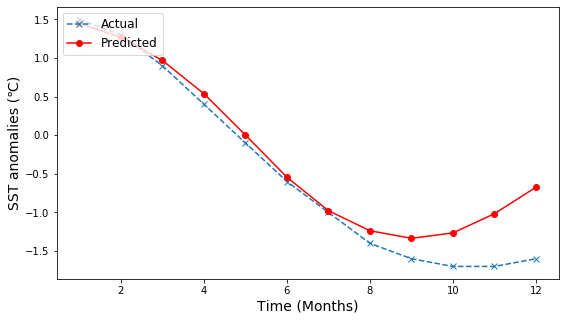

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 


In [ ]:
[1.44767777,1.26778746,0.96792893,0.53676065,0.00248264,-0.54457052,-0.97758015,-1.23768977,-1.33575718,-1.26566679,-1.01696963,-0.67395137]